# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany.<br>
These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns.<br>
The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps.<br>
In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work.<br>
**Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.**<br>
The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [3]:
from Create_Data_Dictionary import create_data_dictionary

In [4]:
def plot_summary( df, xlim=[[],[],[],[],[],[],[]], ylim=[[],[],[],[],[],[],[]]):
    print("================================")
    print('X-Axis is the ID of columns.')
    print('Y-Axis is the value of columns.')
    print("================================")
    plt.rcParams['figure.figsize'] = (16,8);
    plt.subplots_adjust(top=4);
    plt.rcParams['font.size']      = 14;
    #
    x_data      = list(range(df.shape[0]))
    y_list      = ['min', 'mean', 'max', 'std', '25%', '50%', '75%']
    y_data_min  = df['min']
    y_data_mean = df['mean']
    y_data_max  = df['max']
    y_data_std  = df['std']
    colorlist   = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628', '#f781bf', '#ffff33']
    #
    plt.figure();
    #----------------------------------
    for id in range(len(y_list)): 
        plt.subplot(2,4,id+1);
        plt.plot(x_data, df[y_list[id]],  colorlist[id]);
        plt.grid();
        plt.legend([y_list[id]]);

        if len(xlim[id]) >= 2:
            plt.xlim(xlim[id]);
        #
        if len(ylim[id]) >= 2:
            plt.ylim(ylim[id]);

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [5]:
def load_data():
    # Load in the general demographics data.
    azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

    # Load in the feature summary file.
    feat_info  = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

    # Load in Data_Dictionary.md
   #%run -i Create_Data_Dictionary.py
    create_data_dictionary()
    my_dict = pd.read_csv('Data_Dictionary.csv', sep='\t')
    
    return azdias, feat_info, my_dict

### Load Data

In [6]:
azdias, feat_info, my_dict = load_data()

### Check the structure of the data after it's loaded <br>(e.g. print the number of  rows and columns, print the first few rows).

In [7]:
azdias.shape

(891221, 85)

In [8]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [9]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [10]:
my_dict.head()

,id_1,id_2,id_3,name,explanation
0,1,1,101,AGER_TYP,Best-ager typology
1,1,2,102,ALTERSKATEGORIE_GROB,Estimated age based on given name analysis
2,1,3,103,ANREDE_KZ,Gender
3,1,4,104,CJT_GESAMTTYP,Customer-Journey-Typology: preferred informati...
4,1,5,105,FINANZ_MINIMALIST,"Financial typology, for each dimension:"


### I show the summary plot.

X-Axis is the ID of columns.
Y-Axis is the value of columns.


<Figure size 1152x576 with 0 Axes>

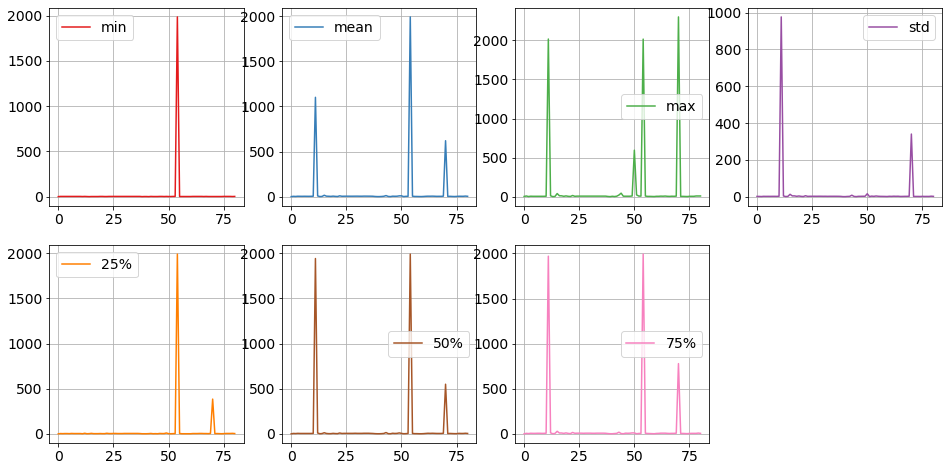

In [11]:
summary_azdias = azdias.describe().T
plot_summary(summary_azdias)

X-Axis is the ID of columns.
Y-Axis is the value of columns.


<Figure size 1152x576 with 0 Axes>

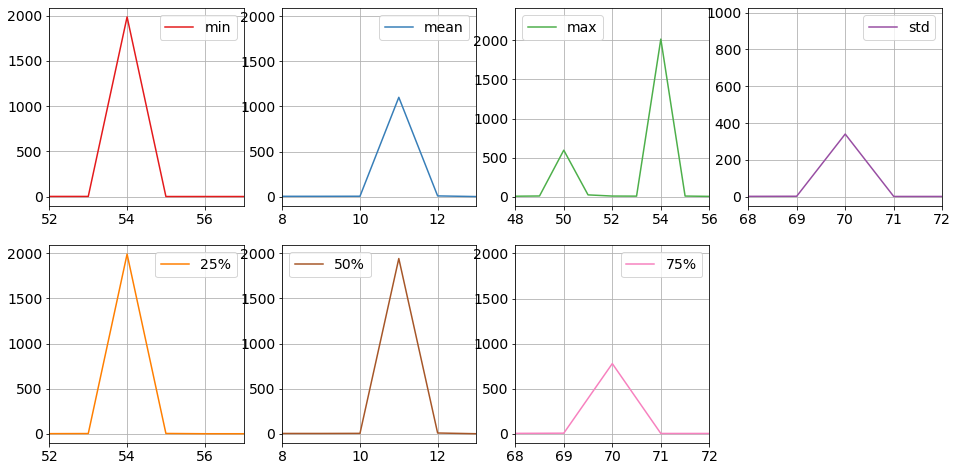

In [12]:
plot_summary(summary_azdias , xlim=[[52,57],[8,13],[48,56],[68,72],[52,57],[8,13],[68,72]])

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [13]:
# Identify missing or unknown data values and convert them to NaNs.

In [14]:
def conv_miss_to_nan(feat_info, azdias, flag_print=0):
    for i in range(feat_info.shape[0]):
        # get the name of column
        col_name     = feat_info.attribute[i]

        # modify string which means 'missing' or 'unknown'
        replace_str  = feat_info.missing_or_unknown[i]
        replace_str  = replace_str.replace('[', '')
        replace_str  = replace_str.replace(']', '')
        replace_str  = replace_str.replace(' ', '')
        replace_list = replace_str.split(',')

        # replacement ['missing' or 'unknown'] => [np.nan]
        for tmp_str in replace_list:
            if (tmp_str == 'X') or (tmp_str == 'XX') or (len(tmp_str)==0):
                pass
            else:
                tmp_str = int(tmp_str)
            #
            azdias[col_name] = azdias[col_name].replace(tmp_str, np.nan )
        
    # Print
    if flag_print:
        print("Head() = \n", azdias.head())
        print("===========================")
        print("===========================")
        print("Describe() = \n", azdias.describe())
    return azdias

In [15]:
def calc_nan(azdias, flag_print=0):
    # Calculate Number of Nan
    sr_nan_col = azdias.isna().sum()
    sr_nan_row = azdias.isna().sum(axis=1)

    # Translation : Series -> DataFrame
    df_nan_col = pd.DataFrame(sr_nan_col)
    df_nan_row = pd.DataFrame(sr_nan_row)
    
    df_nan_col.columns = ['num_nan']
    df_nan_row.columns = ['num_nan']
    
   #azdias = pd.concat([df_nan_row, azdias], axis=1)
    

    # Add Data
    df_nan_col['ratio_nan'] = df_nan_col['num_nan'] / azdias.shape[0] * 100
    df_nan_row['ratio_nan'] = df_nan_row['num_nan'] / azdias.shape[1] * 100
    
    azdias['num_nan']   = df_nan_row['num_nan'].copy()
    azdias['ratio_nan'] = df_nan_row['num_nan'] / azdias.shape[1] * 100
    
    try:
        # 1st
        df_nan_col['ids'] = list(range(azdias.shape[1]-2))
    except:
        # after 2nd
        df_nan_col['ids'] = list(range(azdias.shape[1]))
    #
    df_nan_row['ids'] = list(range(azdias.shape[0]))
    
    # Sort
    azdias     = azdias.sort_values('num_nan', ascending=False)
    df_nan_col = df_nan_col.sort_values('num_nan', ascending=False)
    df_nan_row = df_nan_row.sort_values('num_nan', ascending=False)
    df_nan_row.reset_index(inplace=True, drop=True)
    
    # Print
    if flag_print:
        print("azdias     = \n", azdias.num_nan[:5] )
        print("----------------------------------")        
        print("df_nan_col = \n", df_nan_col.head())
        print("----------------------------------")
        print("df_nan_row = \n", df_nan_row.head())
    
    return df_nan_col, df_nan_row, azdias

In [16]:
# Show Nan Info before convesion.
df_nan_col, df_nan_row, azdias = calc_nan(azdias, flag_print = 1);

azdias     = 
 15284     46
320969    45
704379    45
140317    45
23667     45
Name: num_nan, dtype: int64
----------------------------------
df_nan_col = 
               num_nan  ratio_nan  ids
KK_KUNDENTYP   584612  65.596749   47
KBA05_GBZ      133324  14.959701   65
KBA05_ANTG1    133324  14.959701   60
KBA05_ANTG3    133324  14.959701   62
MOBI_REGIO     133324  14.959701   71
----------------------------------
df_nan_row = 
    num_nan  ratio_nan     ids
0       46  54.117647   15284
1       45  52.941176  320969
2       45  52.941176  704379
3       45  52.941176  140317
4       45  52.941176   23667


In [17]:
azdias = conv_miss_to_nan(feat_info, azdias, flag_print=0)

In [18]:
# Show Nan Info after convesion.
df_nan_col, df_nan_row, azdias = calc_nan(azdias, flag_print = 1);

azdias     = 
 732775    54
33216     53
652820    53
652388    53
628628    53
Name: num_nan, dtype: int64
----------------------------------
df_nan_col = 
               num_nan  ratio_nan  ids
TITEL_KZ       889061  99.757636   40
AGER_TYP       685843  76.955435    0
KK_KUNDENTYP   584612  65.596749   47
KBA05_BAUMAX   476524  53.468668   64
GEBURTSJAHR    392318  44.020282   11
----------------------------------
df_nan_row = 
    num_nan  ratio_nan    ids
0       54  62.068966     37
1       53  60.919540  64392
2       53  60.919540  55185
3       53  60.919540  55190
4       53  60.919540  30644


In [19]:
rows_to_sort   = list(df_nan_col.ids.values)
# my_dict_sorted = my_dict.iloc[rows_to_sort, :]

#### Step 1.1.2: Assess Missing Data in Each Column

- <span style="color: red; ">1 : How much missing data is present in each column?</span>
- There are a few columns that are outliers in terms of the proportion of values that are missing. 
- You will want to use matplotlib's [`hist()`] function to visualize the distribution of missing value counts to find these columns. 
- <span style="color:red"> 2 : Identify and document these columns.</span>
- While some of these columns might have justifications for keeping or re-encoding the data,<br> 
  for this project you should just remove them from the dataframe.<br> 
  (Feel free to make remarks about these outlier columns in the discussion, however!)
- For the remaining features, are there any patterns in which columns have, or share, missing data?

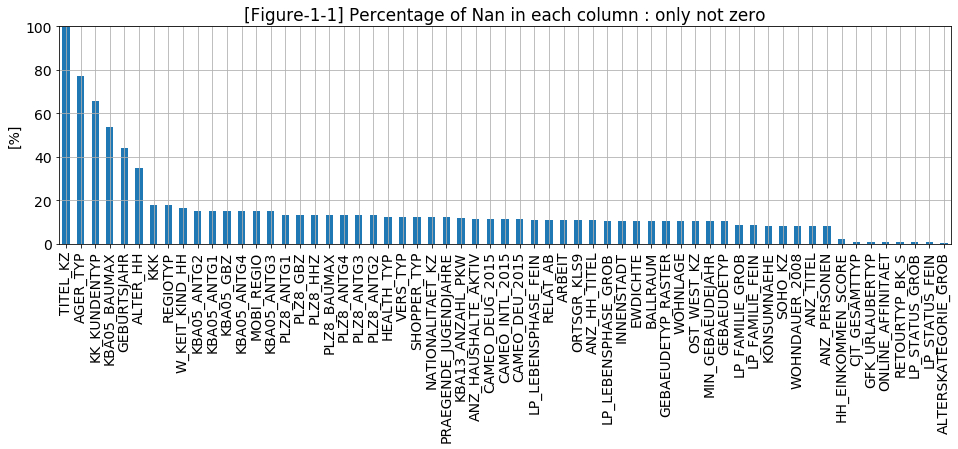

In [20]:
# Perform an assessment of how much missing data there is in each column of the dataset.
# Investigate patterns in the amount of missing data in each column.
plt.rcParams['figure.figsize'] = (16,4)
plt.rcParams['font.size']      = 14
flag_not_zero = df_nan_col.num_nan > 0
ax = df_nan_col.ratio_nan[flag_not_zero].plot(kind='bar')
ax.set_title('[Figure-1-1] Percentage of Nan in each column : only not zero')
ax.set_ylabel('[%]')
ax.set_ylim(0,100)
ax.grid()

In [21]:
for name in df_nan_col.index[:10]:
    tmp_exp = my_dict.loc[my_dict.name==name, :].explanation.values
    print( name + " ---> " + tmp_exp )

['TITEL_KZ ---> Academic title flag']
['AGER_TYP ---> Best-ager typology']
['KK_KUNDENTYP ---> Consumer pattern over past 12 months']
['KBA05_BAUMAX ---> Most common building type within the microcell']
['GEBURTSJAHR ---> Year of birth']
['ALTER_HH ---> Birthdate of head of household']
['KKK ---> Purchasing power in region']
['REGIOTYP ---> Neighborhood typology']
['W_KEIT_KIND_HH ---> Likelihood of children in household']
['KBA05_ANTG2 ---> Number of 3-5 family houses in the microcell']


### Show the columns and explanation which do not have nan.

In [22]:
df_nan_col[df_nan_col.num_nan == 0].index

Index(['ANREDE_KZ', 'num_nan', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'SEMIO_VERT', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP',
       'FINANZ_SPARER', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_LUST', 'ZABEOTYP', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'FINANZ_MINIMALIST', 'ratio_nan'],
      dtype='object')

In [23]:
col_names_without_nan = df_nan_col[df_nan_col.num_nan == 0].index
for name in col_names_without_nan:
    tmp_exp = my_dict.loc[my_dict.name==name, :].explanation.values
    print( name + " ---> " + tmp_exp )

['ANREDE_KZ ---> Gender']
[]
['FINANZ_VORSORGER ---> Financial typology, for each dimension:']
['FINANZ_ANLEGER ---> Financial typology, for each dimension:']
['SEMIO_VERT ---> Personality typology, for each dimension:']
['FINANZ_UNAUFFAELLIGER ---> Financial typology, for each dimension:']
['FINANZ_HAUSBAUER ---> Financial typology, for each dimension:']
['FINANZTYP ---> Most descriptive financial type for individual']
['FINANZ_SPARER ---> Financial typology, for each dimension:']
['GREEN_AVANTGARDE ---> Membership in environmental sustainability as part of youth']
['SEMIO_SOZ ---> Personality typology, for each dimension:']
['SEMIO_FAM ---> Personality typology, for each dimension:']
['SEMIO_REL ---> Personality typology, for each dimension:']
['SEMIO_MAT ---> Personality typology, for each dimension:']
['SEMIO_LUST ---> Personality typology, for each dimension:']
['ZABEOTYP ---> Energy consumption typology']
['SEMIO_ERL ---> Personality typology, for each dimension:']
['SEMIO_KULT -

In [24]:
# Remove the outlier columns from the dataset. 
# (You'll perform other data engineering tasks such as re-encoding and imputation later.)
threshold_to_drop_by_col = 20.0
col_names_to_drop = df_nan_col.index[df_nan_col.ratio_nan > threshold_to_drop_by_col]
print(col_names_to_drop)
azdias.drop(columns=col_names_to_drop , inplace=True )

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')


In [25]:
# Show Nan Info after dropping culomns
df_nan_col, df_nan_row, azdias = calc_nan(azdias, flag_print = 1);

azdias     = 
 732775    49
643174    49
472919    48
425376    47
431612    47
Name: num_nan, dtype: int64
----------------------------------
df_nan_col = 
                 num_nan  ratio_nan  ids
REGIOTYP         158064  17.735668   67
KKK              158064  17.735668   64
W_KEIT_KIND_HH   147988  16.605084   43
MOBI_REGIO       133324  14.959701   65
KBA05_ANTG4      133324  14.959701   58
----------------------------------
df_nan_row = 
    num_nan  ratio_nan    ids
0       49  60.493827      0
1       49  60.493827  30582
2       48  59.259259  46125
3       47  58.024691  30445
4       47  58.024691  30383


#### Discussion 1.1.2: Assess Missing Data in Each Column
<span style="color:red">
Q1 : Report your observations regarding the amount of missing data in each column.<br>
Q2 : Are there any patterns in missing values? Which columns were removed from the dataset?
</span>    

#### Discussion 1.1.2: <span style="color:red">Answer</span>
##### A1 : 
- I show the result with the above figure(1-1 & 1-2).

##### A2: 
- Top 6 data have over 30% nan. So I removed those columns.
- Other data have only less than 20% nan. So I want to interpolate those nan and use those column to learn.
- The columns which have no nan are belonged to the group of "1. Person-level features".

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset.<br>
How much data is missing in each row? <br>
As with the columns, you should see some groups of points that have a very different numbers of missing values. <br>
<span style="color:red">Divide the data into two subsets:<br>
    1 : one for data points that are above some threshold for missing values<br>
    2 : second subset for points below that threshold.
</span><br>

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups.<br>

<span style="color:red">3 : Select at least five of these columns and compare the distribution of values.</span>

- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. <br>

If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. <br>

On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. <br>

We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [26]:
# How much data is missing in each row of the dataset?

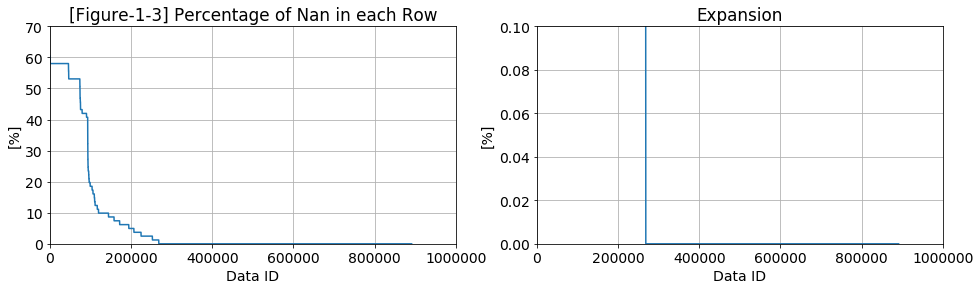

In [27]:
plt.rcParams['figure.figsize'] = (16,4)
x_data   = list(range(df_nan_row.shape[0]))
y_data   = df_nan_row.ratio_nan.values
#
plt.subplot(1,2,1)
plt.plot(x_data, y_data);
plt.grid();
plt.xlabel('Data ID')
plt.ylabel('[%]')
plt.xlim(0,1000000)
plt.ylim(0,70)
plt.title('[Figure-1-3] Percentage of Nan in each Row');
#
plt.subplot(1,2,2)
plt.plot(x_data, y_data);
plt.grid();
plt.xlabel('Data ID')
plt.ylabel('[%]')
plt.xlim(0,1000000)
plt.ylim(0,0.1)
plt.title('Expansion');

In [28]:
num_wo_nan  = df_nan_row[df_nan_row.num_nan == 0].shape[0]
num_w_nan   = df_nan_row[df_nan_row.num_nan > 0].shape[0]
ratio_w_nan = num_w_nan / ( num_wo_nan + num_w_nan ) * 100
print( "number of data without nan = ",  num_wo_nan)
print( "number of data with    nan = ",  num_w_nan)
print( "ratio  of data with    nan =  {:.1f} [%]".format(ratio_w_nan) )

number of data without nan =  623209
number of data with    nan =  268012
ratio  of data with    nan =  30.1 [%]


### From the above data,
- ratio of data with nan is about 30 %.
- If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, I am going to drop all the data with nan.

In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

In [30]:
def devide_df_by_row(df, devide_num = 5):
    df_devided = []
    #
    for i in range(devide_num):
        id_start = int(df.shape[0]/devide_num)*i
        id_end   = int(df.shape[0]/devide_num)*(i+1)
        #
        if id_end > df.shape[0]:
            id_end = df.shape[0]
        #
        #print("id_start={} / id_end={}".format(id_start, id_end))
        df_devided.append( df.iloc[id_start:id_end, :] )
    #
    return df_devided

In [31]:
def countplot_for_devided_df(df_list, col_names, fig_size=(30,60), font_size=14, top=2.0 ): 
    plt.rcParams['figure.figsize'] = fig_size;
    plt.rcParams['font.size']      = font_size;
    plt.figure();
    plt.subplots_adjust(top=top)
    counter    = 0
    devide_num = len(df_list)
    #
    for i, col_name in enumerate(col_names):
        for j in range(devide_num):
            counter += 1
            plt.subplot( len(col_names) , devide_num, counter)
            #
            try:
                sns.countplot(x = col_name, data=df_list[j]);
            except:
                print('<No Data> : Column = {}, i = {}, j = {}'.format(col_name, i,j))        
            #            
            if i == 0:
                plt.title("RowID=" + str(j+1))    
            #
            if counter%devide_num == 1:
                plt.ylabel(col_name)

### Devide the DataFrame to get the CountPlots

In [32]:
azdias_devided = devide_df_by_row(azdias, devide_num = 10)

### Compare the distribution of values <br>for at least five columns where there are no or few missing values, between the two subsets.

### Explanation of the function " countplot_for_devided_df ".
- The difference "RowID=X" is "Data ID". See Figure-1-3.
- The difference of rows is column name.
- "RowID=1" is the group which has the largest percentage of nan.
- Here, I used the columns which have no nan.

In [33]:
a = ['num_nan', 'a', 'b']
b = a != 'num_nan'
print(b)

True


In [34]:
col_names_without_nan = df_nan_col.index[df_nan_col.num_nan == 0].values
print("------------------------------")
print(len(col_names_without_nan))
print("------------------------------")
print(col_names_without_nan)

------------------------------
26
------------------------------
['ANREDE_KZ' 'ZABEOTYP' 'num_nan' 'FINANZ_MINIMALIST' 'FINANZ_SPARER'
 'FINANZ_VORSORGER' 'FINANZ_ANLEGER' 'FINANZ_UNAUFFAELLIGER'
 'FINANZ_HAUSBAUER' 'FINANZTYP' 'GREEN_AVANTGARDE' 'SEMIO_SOZ' 'SEMIO_FAM'
 'SEMIO_REL' 'SEMIO_MAT' 'SEMIO_VERT' 'SEMIO_LUST' 'SEMIO_ERL'
 'SEMIO_KULT' 'SEMIO_RAT' 'SEMIO_KRIT' 'SEMIO_DOM' 'SEMIO_KAEM'
 'SEMIO_PFLICHT' 'SEMIO_TRADV' 'ratio_nan']


[Figure-1-4] CountPlot. (I used the columns which have no nan.)


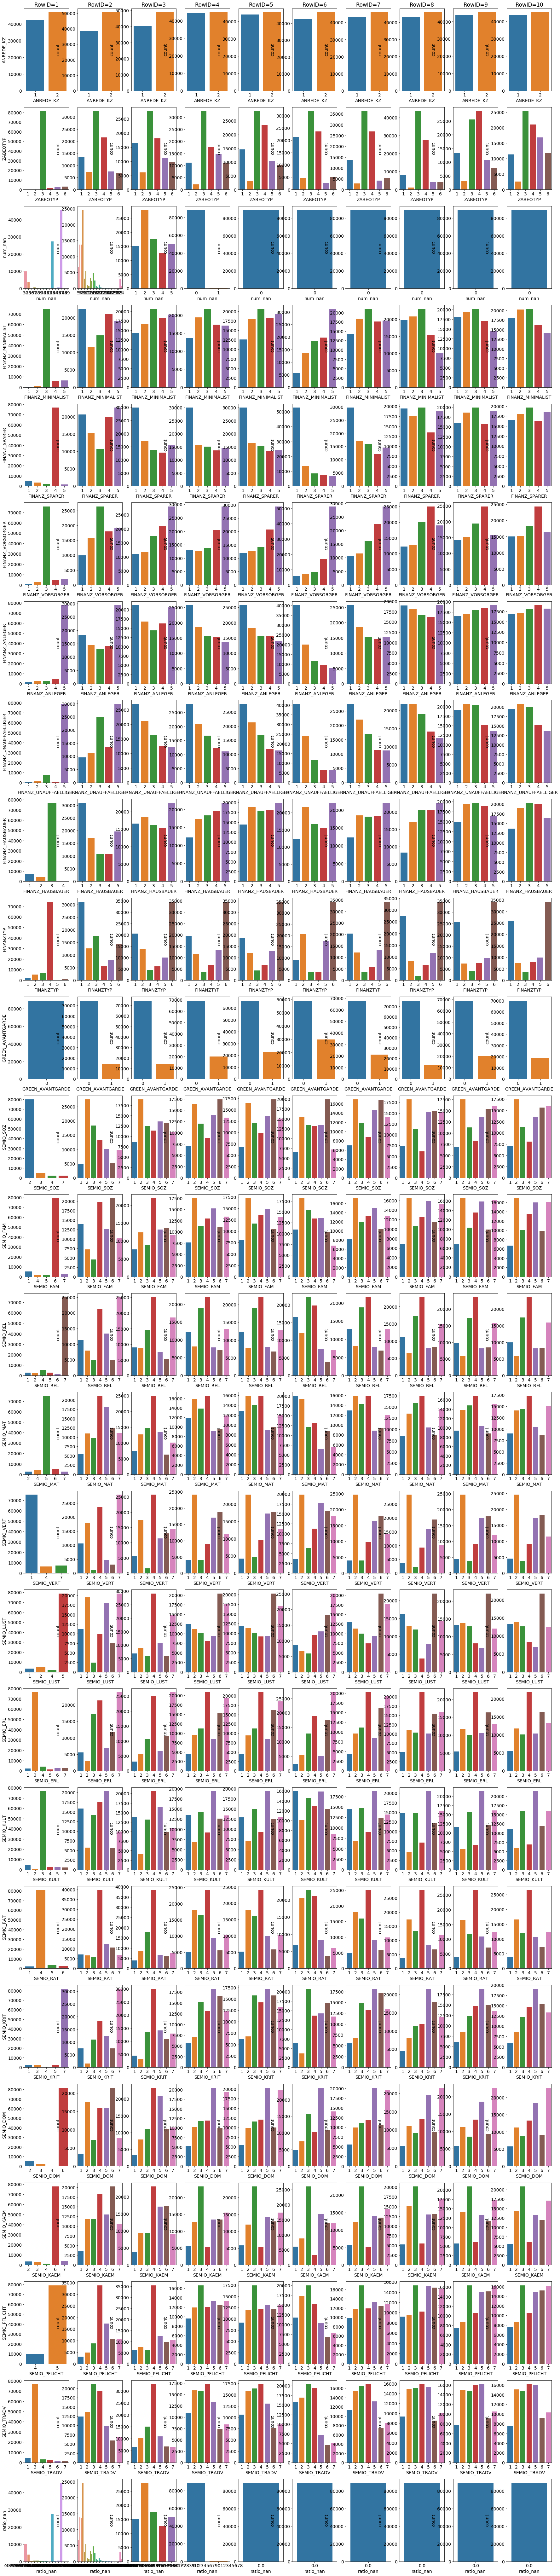

In [35]:
countplot_for_devided_df(azdias_devided, col_names_without_nan, fig_size=(30,60), font_size=14, top=2.0 )
print('[Figure-1-4] CountPlot. (I used the columns which have no nan.)')

#### Discussion 1.1.3: Assess Missing Data in Each Row
<span style="color:red">
Q3 : Report your observations regarding missing data in rows.<br>
Q4 : Are the data with lots of missing values are qualitatively different from data with few or no missing values?
</span>   

#### Discussion 1.1.3: <span style="color:red">Answer</span>
##### A3 : 
- I show the result with the above figure(1-3 & 1-4).

##### A4: 
- No. 
- Tendency of plots from col=7 to col=10 is similar.
- Tendency of plots from col=4 to col=10 is also similar but tendency of some features are not similar.
- Tendency of plots from col=1 to col=3  is random.

### Summary
- If there is enough infomation, I use the data from col=7 to col=10.
- If there is not enough information, I use the data from col=4 to col=10.
- The ratio of rows which have no nan is about 70%. (I showed above.)
- So, for 1st trial, I am going to use the data which have no nan.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis.<br>
Since the unsupervised learning techniques to be used will only work on data that is encoded numerically,<br>
you need to make a few encoding changes or additional assumptions to be able to make progress.<br>
In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values.<br>
<span style="color:red">
1 : Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
</span>
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step,<br>

<span style="color:red"> 
2 : you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. 
</span> 

<span style="color:red"> 
3 : Then, in the last part, you will create a new data frame with only the selected and engineered columns.
</span> 

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here.<br>
But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [36]:
# How many features are there of each data type?

### 1 : Check the third column of the feature summary (feat_info) for a summary of types of measurement.
- There are 5 data types.

In [37]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [38]:
data_types = list( feat_info.iloc[:,2].unique() )
print("data_types      = ", data_types)
print("len(data_types) = ", len(data_types))

data_types      =  ['categorical', 'ordinal', 'numeric', 'mixed', 'interval']
len(data_types) =  5


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [39]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

### Show Unique Values of <span style="color:red"> Categorical </span>

In [40]:
def get_df_feature(feat_info, azdias, col_names, flag_plot=0):
    binary_num = []
    binary_str = []
    multi_num  = []
    multi_str  = []
    type_str   = "<class " + "\'str\'>"
    
    #
    for col_name in col_names:
        print("-----------------------------")
        print("< ", col_name, " >")
        try:
            val_unique   = azdias[col_name].dropna().unique()
            current_type = str( type(val_unique[0]) )
            print( val_unique )
           #print( feat_info.type[feat_info.attribute == col_name].values)
            #
            if len(val_unique) == 2:
                if current_type == type_str:
                    binary_str.append(col_name)
                else:
                    binary_num.append(col_name)
            else:
                if current_type == type_str:
                    multi_str.append(col_name)
                else:
                    multi_num.append(col_name)
        except:
            print("---> There is no data. This is already dropped.")
    #
    if flag_plot:
        print("=====================================")
        print("binary_num = \n", binary_num)
        print("=====================================")
        print("binary_str = \n", binary_str)
        print("=====================================")
        print("multi_num = \n", multi_num)
        print("=====================================")
        print("multi_str = \n", multi_str)        
    return binary_num, binary_str, multi_num, multi_str

In [41]:
col_names = feat_info.attribute[feat_info.type == 'categorical']
binary_num, binary_str, multi_num, multi_str = get_df_feature(feat_info, azdias, col_names, flag_plot=0)

-----------------------------
<  AGER_TYP  >
---> There is no data. This is already dropped.
-----------------------------
<  ANREDE_KZ  >
[2 1]
-----------------------------
<  CJT_GESAMTTYP  >
[6. 5. 4. 2. 3. 1.]
-----------------------------
<  FINANZTYP  >
[4 2 3 6 1 5]
-----------------------------
<  GFK_URLAUBERTYP  >
[ 5.  3.  8.  1.  4. 12.  9. 10.  6. 11.  7.  2.]
-----------------------------
<  GREEN_AVANTGARDE  >
[0 1]
-----------------------------
<  LP_FAMILIE_FEIN  >
[ 1. 10. 11.  2.  9.  7.  3.  4.  6.  5.  8.]
-----------------------------
<  LP_FAMILIE_GROB  >
[1. 5. 2. 4. 3.]
-----------------------------
<  LP_STATUS_FEIN  >
[ 5.  2.  4.  7.  6.  1.  9.  8. 10.  3.]
-----------------------------
<  LP_STATUS_GROB  >
[2. 1. 3. 4. 5.]
-----------------------------
<  NATIONALITAET_KZ  >
[2. 3. 1.]
-----------------------------
<  SHOPPER_TYP  >
[1. 3. 2. 0.]
-----------------------------
<  SOHO_KZ  >
[0. 1.]
-----------------------------
<  TITEL_KZ  >
---> There is

### Policy to modify <span style="color:red"> Categorical </span>
- 1: binary-numerical      => pass
- 2: binary-string         => 0 or 1
- 3: multi-level-numerical => one-hot-encoding
- 4: multi-level-string    => one-hot-encoding

### Policy-1 : Pass

### Policy-2

In [42]:
def modify_binary_string(azdias, col_name):
    val_unique = azdias[col_name].unique()
    #
    for i, tmp_val in enumerate( val_unique ):
        azdias[col_name] = azdias[col_name].replace(tmp_val, float(i) )
    #
    return azdias

In [43]:
for col_name in binary_str:
    azdias = modify_binary_string(azdias, col_name)

### Policy-3 : One-Hot-Encoding

In [44]:
# Re-encode categorical variable(s) to be kept in the analysis.
def my_one_hot(azdias, col_name, flag_merge=0, flag_drop=0):
    if not col_name in azdias.columns: 
        print("There is not ", col_name)
        return [], azdias
    #    
    tmp_df        = pd.get_dummies(azdias[col_name])
    col_names_new = []
    #
    for i in range(tmp_df.shape[1]):
        col_names_new.append(col_name + "_" +str(i))
    #
    tmp_df.columns = col_names_new
    #
    if flag_merge:
        azdias = pd.concat([azdias, tmp_df], axis=1)
        
        if flag_drop:
            azdias.drop(columns=[col_name], inplace=True)
    #
    return tmp_df, azdias

In [45]:
for col_name in multi_num:
    tmp_df, azdias = my_one_hot(azdias, col_name, flag_merge=1, flag_drop=1)

### Policy-4 : One-Hot-Encoding

In [46]:
for col_name in multi_str:
    tmp_df, azdias = my_one_hot(azdias, col_name, flag_merge=1, flag_drop=1)

In [47]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_34,CAMEO_DEU_2015_35,CAMEO_DEU_2015_36,CAMEO_DEU_2015_37,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43
732775,3.0,2,3,5,3,5,5,2,0,NaN,...,0,0,0,0,0,0,0,0,0,0
643174,3.0,1,2,5,3,5,5,2,0,NaN,...,0,0,0,0,0,0,0,0,0,0
472919,1.0,1,5,1,5,2,3,2,0,NaN,...,0,0,0,0,0,0,0,0,0,0
425376,3.0,1,3,4,3,5,5,3,0,NaN,...,0,0,0,0,0,0,0,0,0,0
431612,2.0,2,3,4,3,5,5,3,0,NaN,...,0,0,0,0,0,0,0,0,0,0


In [48]:
azdias.shape

(891221, 196)

#### Discussion 1.2.1: Re-Encode Categorical Features
<span style="color:red">
Q5 : Report your findings and decisions regarding categorical features.<br>
Q6 : Which ones did you keep, which did you drop, and what engineering steps did you perform?
</span>

#### Discussion 1.1.3: <span style="color:red">Answer</span>
##### A5 : 
- I show the result above.

##### A6: 
- I show the result above. See the Policy 1 to 4.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- <span style="color:green">"PRAEGENDE_JUGENDJAHRE"</span> combines information on three dimensions: <br>
<span style="color:red">
1 : generation by decade<br>
2 : movement (mainstream vs. avantgarde)<br>
3 : nation (east vs. west). <br>
</span>
While there aren't enough levels to disentangle east from west, you should create <span style="color:red">two new variables</span> to capture the other two dimensions: <br>
<span style="color:red">
1 : an interval-type variable for decade<br>
2 : a binary variable for movement<br>
</span>

- <span style="color:green">"CAMEO_INTL_2015"</span> combines information on two axes: 
<span style="color:red">
1 : wealth<br>
2 : life stage<br>
</span>
Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### I show the unique value of the column whose type is "mixed".

In [49]:
col_names = feat_info.attribute[feat_info.type == 'mixed']
binary_num, binary_str, multi_num, multi_str = get_df_feature(feat_info, azdias, col_names, flag_plot=1)

-----------------------------
<  LP_LEBENSPHASE_FEIN  >
[13.  4. 32.  5. 40.  9.  8. 37. 11.  7.  1. 15. 24. 31. 30. 28. 20. 29.
 16.  6.  3. 12. 10. 39.  2. 35. 18. 21. 23. 36. 26. 14. 34. 22. 25. 33.
 38. 27. 19. 17.]
-----------------------------
<  LP_LEBENSPHASE_GROB  >
[ 3.  4.  1. 10.  2. 12.  7.  9.  8.  5. 11.  6.]
-----------------------------
<  PRAEGENDE_JUGENDJAHRE  >
[ 8. 14.  5.  1.  3. 11. 10. 15. 13.  9.  7.  4. 12.  6.  2.]
-----------------------------
<  WOHNLAGE  >
[0. 7. 1. 8. 5. 3. 2. 4.]
-----------------------------
<  CAMEO_INTL_2015  >
['22' '25' '13' '24' '31' '23' '14' '12' '55' '51' '54' '43' '34' '33'
 '35' '41' '44' '45' '15' '32' '52']
-----------------------------
<  KBA05_BAUMAX  >
---> There is no data. This is already dropped.
-----------------------------
<  PLZ8_BAUMAX  >
[1. 2. 3. 4. 5.]
binary_num = 
 []
binary_str = 
 []
multi_num = 
 ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'PLZ8_BAUMAX']
multi_str = 

In [50]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

In [51]:
def modify_PRAEGENDE(azdias):
    azdias['PRAEGENDE_JUGENDJAHRE_Decade'] = azdias['PRAEGENDE_JUGENDJAHRE'].copy(deep=True)
    azdias['PRAEGENDE_JUGENDJAHRE_Move']   = azdias['PRAEGENDE_JUGENDJAHRE'].copy(deep=True)
    #
    value_Decade = [400,400, 500,500, 600,600,600, 700,700, 800,800,800,800, 900,900]
    value_Move = [  1,  0,   1,  0,   1,  0,  0,   1,  0,   1,  0,  1, 0 ,   1, 0]
    #
    for i in range(15):
        found_flag = azdias['PRAEGENDE_JUGENDJAHRE_Decade'] == (i+1)
        # [ ]が複数回続く連続処理は、うまく代入ができない
        #azdias['PRAEGENDE_JUGENDJAHRE_Decade'][found_flag]   = value_Decade[i]
        #azdias['PRAEGENDE_JUGENDJAHRE_Move'][found_flag]   = value_Move[i]
        azdias.loc[found_flag, 'PRAEGENDE_JUGENDJAHRE_Decade']   = value_Decade[i]
        azdias.loc[found_flag, 'PRAEGENDE_JUGENDJAHRE_Move'  ]   = value_Move[i]
    #
    azdias['PRAEGENDE_JUGENDJAHRE_Decade'] = azdias['PRAEGENDE_JUGENDJAHRE_Decade'] / 100
    azdias.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)
    return azdias

In [52]:
azdias = modify_PRAEGENDE(azdias);

In [53]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

In [54]:
def modify_CAMEO_INTL_2015(azdias):
    azdias['CAMEO_INTL_2015_1'] = azdias['CAMEO_INTL_2015'].copy(deep=True)
    azdias['CAMEO_INTL_2015_2'] = azdias['CAMEO_INTL_2015'].copy(deep=True)
    #
    for i in range(60):
        found_flag = azdias['CAMEO_INTL_2015'] == (i+1)
        #-----------------------------------------
        value_1    = i % 10
        #
        if i > 9:
            value_2 = i - value_1
        else:
            value_2 = 0
        #-----------------------------------------
        azdias.loc[found_flag, 'CAMEO_INTL_2015_1'] = value_1
        azdias.loc[found_flag, 'CAMEO_INTL_2015_2'] = value_2/10
    azdias.drop(columns=['CAMEO_INTL_2015'], inplace=True)
    return azdias

In [55]:
azdias = modify_CAMEO_INTL_2015(azdias)

In [56]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,PRAEGENDE_JUGENDJAHRE_Decade,PRAEGENDE_JUGENDJAHRE_Move,CAMEO_INTL_2015_1,CAMEO_INTL_2015_2
732775,3.0,2,3,5,3,5,5,2,0,NaN,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
643174,3.0,1,2,5,3,5,5,2,0,NaN,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
472919,1.0,1,5,1,5,2,3,2,0,NaN,...,0,0,0,0,0,0,7.0,1.0,NaN,NaN
425376,3.0,1,3,4,3,5,5,3,0,NaN,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
431612,2.0,2,3,4,3,5,5,3,0,NaN,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN


#### Discussion 1.2.2: Engineer Mixed-Type Features
<span style="color:red">
Q7 : Report your findings and decisions regarding mixed-value features.<br>
Q8 : Which ones did you keep, which did you drop, and what engineering steps did you perform?
</span>    

#### Discussion 1.2.2: <span style="color:red">Answer</span>
##### A7 : 
- The data whose type is "mixed" are multi-level.

##### A8: 
- I did not drop any columns.
- "PRAEGENDE" and "CAMEO_INTL_2015" were modified as the instruction.
- Other data are also the candidate of modification(e.g. One-Hot-Encoding ), <br>
but if I use One-Hot-Encoding, the amount of data becomes too large,
- So, Here, I do not modify those colums.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [57]:
print("Show the shape of azdias before removing data.")
print(azdias.shape)

Show the shape of azdias before removing data.
(891221, 198)


In [58]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

### Drop all nan data

In [59]:
azdias = azdias.loc[azdias.num_nan==0, :].copy(deep=True)
print("shape   = ", azdias.shape)
print("num_nan = ", azdias.isna().sum().sum())

shape   =  (623209, 198)
num_nan =  0


In [60]:
azdias.drop(columns=['num_nan', 'ratio_nan'], inplace=True)
print("shape   = ", azdias.shape)

shape   =  (623209, 196)


In [61]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

### Check the outlier data

In [62]:
summary_azdias = azdias.describe().T

In [63]:
summary_azdias.head()

,count,mean,std,min,25%,50%,75%,max
ALTERSKATEGORIE_GROB,623209.0,2.792540,1.026485,1.0,2.0,3.0,4.0,4.0
ANREDE_KZ,623209.0,1.511211,0.499875,1.0,1.0,2.0,2.0,2.0
FINANZ_MINIMALIST,623209.0,3.057793,1.360774,1.0,2.0,3.0,4.0,5.0
FINANZ_SPARER,623209.0,2.677015,1.469261,1.0,1.0,3.0,4.0,5.0
FINANZ_VORSORGER,623209.0,3.451430,1.388873,1.0,2.0,4.0,5.0,5.0


### All range

X-Axis is the ID of columns.
Y-Axis is the value of columns.


<Figure size 1152x576 with 0 Axes>

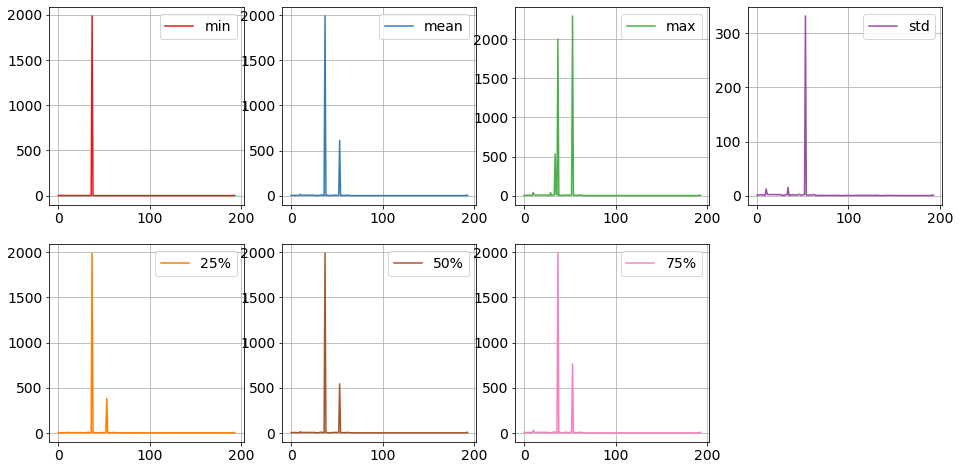

In [64]:
plot_summary( summary_azdias );

### with y limitation

X-Axis is the ID of columns.
Y-Axis is the value of columns.


<Figure size 1152x576 with 0 Axes>

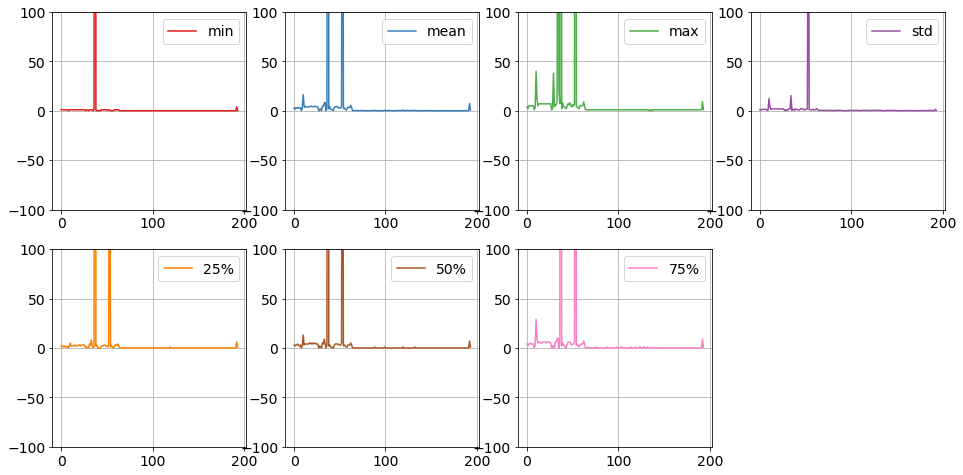

In [65]:
plot_summary(summary_azdias,ylim=[[-100,100],[-100,100],[-100,100],[-100,100],[-100,100],[-100,100],[-100,100]])

### I am going to remove the outlier columns.

In [66]:
def flatten(data):
    out = []
    for i in range(len(data)):
        sub_data = data[i]
        for j in range(len(sub_data)):
            out.append(sub_data[j])
    return out

In [67]:
outlier_list = []
col_names    = ['min','max','mean','std','25%','50%','75%']
#
for col_name in col_names:
    outlier_list.append(list( summary_azdias.index[summary_azdias[col_name] > 50]))
#
outliers_all = flatten(outlier_list)

In [68]:
outliers_all

['MIN_GEBAEUDEJAHR',
 'ANZ_HAUSHALTE_AKTIV',
 'MIN_GEBAEUDEJAHR',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR',
 'KBA13_ANZAHL_PKW',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR',
 'KBA13_ANZAHL_PKW']

### I show the unique column names of outliers.

In [69]:
df_ouliers_all = pd.DataFrame(outliers_all)
df_ouliers_all.columns = ['name']
col_names_of_outliers  = df_ouliers_all.name.unique()
print(col_names_of_outliers)

['MIN_GEBAEUDEJAHR' 'ANZ_HAUSHALTE_AKTIV' 'KBA13_ANZAHL_PKW']


### So, I drop those columns.

In [70]:
print("shape before = ", azdias.shape)
azdias.drop(columns=col_names_of_outliers, inplace=True)
print("shape after  = ", azdias.shape)

shape before =  (623209, 196)
shape after  =  (623209, 193)


### Show the data distribution after dropping the outliers

In [71]:
summary_azdias = azdias.describe().T

X-Axis is the ID of columns.
Y-Axis is the value of columns.


<Figure size 1152x576 with 0 Axes>

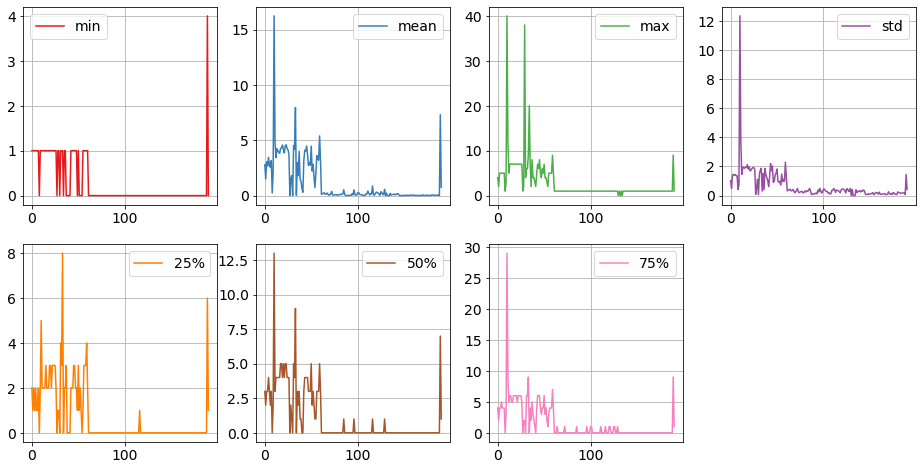

In [72]:
plot_summary( summary_azdias )

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [73]:
def clean_data(df_target, df_feature, my_dict):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    summary_df_target = df_target.describe().T
    df_target = conv_miss_to_nan(df_feature, df_target, flag_print=0)
    df_nan_col, df_nan_row, df_target = calc_nan(df_target, flag_print = 1);
    rows_to_sort   = list(df_nan_col.ids.values)
    my_dict_sorted = my_dict.iloc[rows_to_sort, :]

    # remove selected columns
    threshold_ratio_to_drop_by_col = 20.0 # [%]
    col_names_to_drop = df_nan_col.index[df_nan_col.ratio_nan > threshold_ratio_to_drop_by_col]
    df_target.drop(columns=col_names_to_drop , inplace=True )
    df_nan_col, df_nan_row ,df_target= calc_nan(df_target, flag_print=0)
    
    # remove selected rows
    threshold_ratio_to_drop_by_row = 0.0001 # [%]
    rows_to_remain = df_nan_row.index[df_nan_row.ratio_nan < threshold_ratio_to_drop_by_row]
    df_target = df_target.iloc[rows_to_remain, :]
    
    # select, re-encode, and engineer column values.
    # < Categorical >
    col_names = df_feature.attribute[df_feature.type == 'categorical']
    binary_num, binary_str, multi_num, multi_str = get_df_feature(df_feature, df_target, col_names, flag_plot=0)
    
    # Policy-2
    for col_name in binary_str:
        df_target = modify_binary_string(df_target, col_name)
    
    # Policy-3
    for col_name in multi_num:
        tmp_df, df_target = my_one_hot(df_target, col_name, flag_merge=1, flag_drop=1) 
        
    # Policy-4
    for col_name in multi_str:
        tmp_df, df_target = my_one_hot(df_target, col_name, flag_merge=1, flag_drop=1)
    
    # < Mixed >
    try:
        df_target = modify_PRAEGENDE(df_target);
    except:
        print('-----------------------------')
        print('<  PRAEGENDE_JUGENDJAHRE  >')
        print('---> There is no data. This is already dropped.')
    #
    try:
        df_target = modify_CAMEO_INTL_2015(df_target)
    except:
        print('-----------------------------')
        print('<  CAMEO_INTL_2015  >')
        print('---> There is no data. This is already dropped.')
    #
    # Drop All Nan
    df_target = df_target.loc[df_target.num_nan==0, :].copy(deep=True)
    
    # Drop unnecessary columns
    df_target.drop(columns=['num_nan', 'ratio_nan'], inplace=True)
    
    # Drop outliers
    outlier_list = []
    col_names    = ['min','max','mean','std','25%','50%','75%']
    #
    summary_df_target2 = df_target.describe().T
    #
    for col_name in col_names:
        outlier_list.append(list( summary_df_target2.index[summary_df_target2[col_name] > 50]))
    #
    outliers_all = flatten(outlier_list)
    #
    if len(outliers_all) > 0:
        df_ouliers_all = pd.DataFrame(outliers_all)
        df_ouliers_all.columns = ['name']
        col_names_of_outliers  = df_ouliers_all.name.unique()    
        #
        df_target.drop(columns=col_names_of_outliers, inplace=True)

    # Return the cleaned dataframe.
    return df_target

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [74]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

In [75]:
print("num of nan = " , azdias.isna().sum(axis=1).sum() )

num of nan =  0


In [76]:
azdias.shape

(623209, 193)

In [77]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(azdias)

In [78]:
azdias_scaled = pd.DataFrame(X)
azdias_scaled.columns = azdias.columns

### Show the data distribution after scaling

In [79]:
summary_azdias_scaled = azdias_scaled.describe().T

### Before Scaling

X-Axis is the ID of columns.
Y-Axis is the value of columns.


<Figure size 1152x576 with 0 Axes>

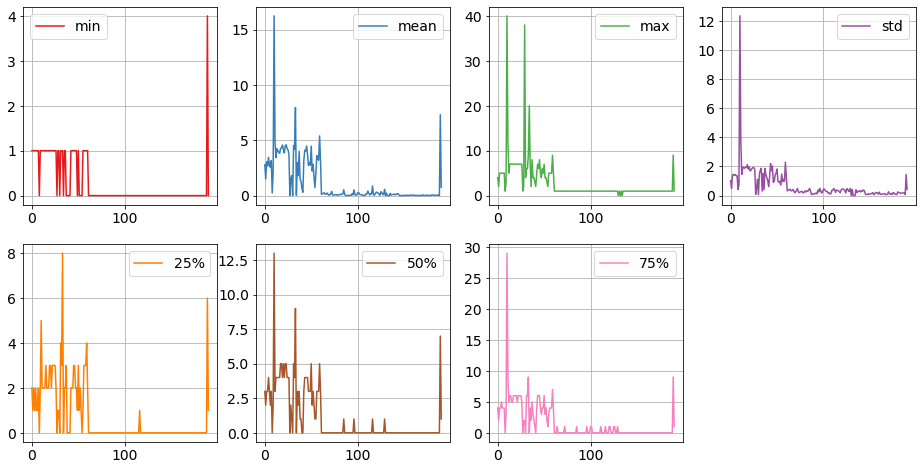

In [80]:
plot_summary( summary_azdias );

### After Scaling

X-Axis is the ID of columns.
Y-Axis is the value of columns.


<Figure size 1152x576 with 0 Axes>

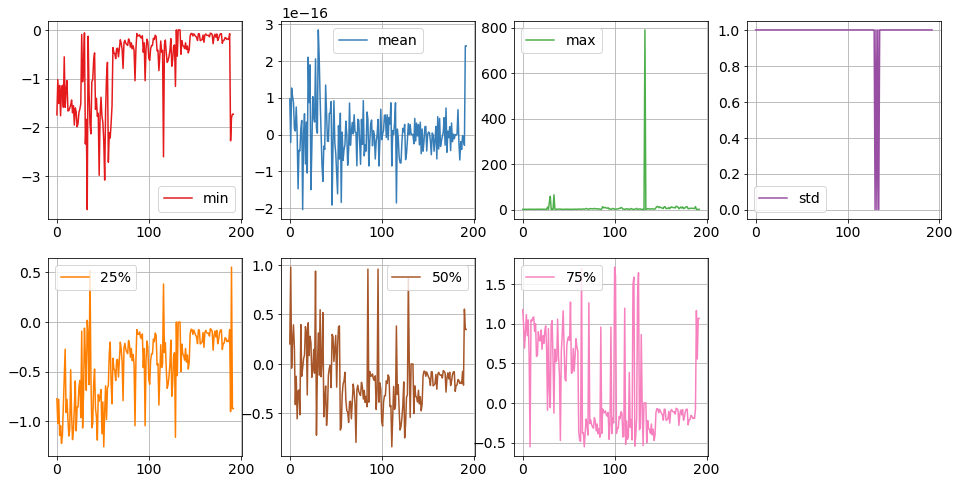

In [81]:
plot_summary( summary_azdias_scaled );

### Discussion 2.1: Apply Feature Scaling
<span style="color:red">
Q9 :  Report your decisions regarding feature scaling.
</span>    

### Discussion 2.1: <span style="color:red">Answer</span>
##### A9 : 
- There is a few outlies, but the resutls of scaling is good.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data,<br>
1 : thus finding the vectors of maximal variance in the data.<br>
2 : To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained.<br>
3 : Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function.<br>
4 : Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, <br>
5 : make sure you re-fit a PCA instance to perform the decided-on transformation.

In [82]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
from time import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

C:\Users\mbd_p\Anaconda3\envs\UdaCity_01_Intro_ML\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Standarize the DataFrame

In [83]:
azdias_standarized = StandardScaler().fit_transform(azdias_scaled)
print( type(azdias_standarized))

<class 'numpy.ndarray'>


In [84]:
def do_pca(data, n_components=0):
    if n_components == 0:
        model_pca = PCA()
    else:
        model_pca = PCA(n_components)
    #
    data_reductioned = model_pca.fit_transform(data)
    return model_pca, data_reductioned

In [85]:
def my_scree_plot(model_pca):
    # PCAオブジェクトの情報を取得
    val_components = model_pca.explained_variance_ratio_
    num_components = len(val_components)
    
    # 順次、蓄積する総和
    val_cumsum = np.cumsum(val_components)
    
    # Plot
    plt.rcParams['font.size'] = 14
    plt.rcParams['figure.figsize'] = (10,6)
    indices = list(range(num_components)) # 横軸に使う
    #
    plt.bar(indices,  val_components*100);
    plt.plot(indices, val_cumsum*100, 'ro-');
    plt.grid();
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained [%]")
    plt.title("Explained Variance Per Principal Component")
    
    #装飾する
    for i in range(num_components):
        tmp_val = val_components[i] * 100
        tmp_str = "{0:.2f}".format(tmp_val) + "%"
        tmp_x   = indices[i] + 0.2
        tmp_y   = val_components[i]*100
        
        if i%10 == 0:
            plt.annotate(tmp_str, (tmp_x, tmp_y), va="bottom", ha="center", fontsize=14)

In [86]:
# Investigate the variance accounted for by each principal component.

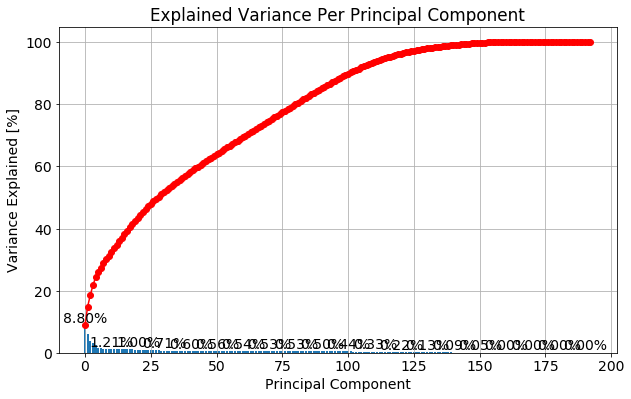

In [87]:
n_components = 0
model_pca, data_reductioned = do_pca( azdias_standarized, n_components)
my_scree_plot(model_pca);

In [88]:
# Re-apply PCA to the data while selecting for number of components to retain.

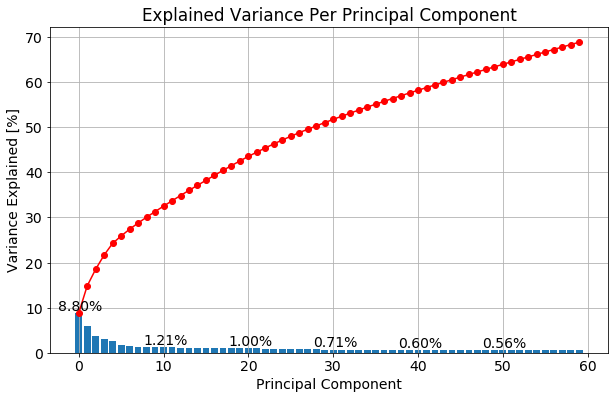

In [89]:
n_components = 60
model_pca, data_reductioned = do_pca( azdias_standarized, n_components)
my_scree_plot(model_pca);

### data_reductioned ( = pca.fit_transform(data) )
- I show the data whose degree of freedom is reduced 

In [90]:
print(type(data_reductioned))
print(data_reductioned.shape)
print("------------------")
print(data_reductioned[:5, :5])

<class 'numpy.ndarray'>
(623209, 60)
------------------
[[-2.54922687  1.00481263 -5.50318268 -3.09811105  0.18826279]
 [ 3.68177212 -0.80464634 -0.24220144 -6.56127965  0.49065118]
 [ 6.83852587 -1.49420854  0.52945349 -4.56134631  2.06899242]
 [ 5.38216587 -3.9402851   2.24141826  3.14499698  0.40762332]
 [ 0.88350363  4.25969098  4.60722838  3.92748741  2.719965  ]]


In [91]:
print(type(model_pca))

<class 'sklearn.decomposition.pca.PCA'>


### model_pca.components_
- row = dimension
- col = columns of the original dataframe
- val = eigen vector in each dimension

In [92]:
print(model_pca.components_.shape)
print("------------------")
print(np.round( model_pca.components_[:5, :5],4) )

(60, 193)
------------------
[[ 0.0869 -0.0085  0.1814 -0.1099  0.0846]
 [-0.2354 -0.0396 -0.0884  0.2248 -0.2136]
 [-0.0206  0.3339 -0.1297  0.0526 -0.0467]
 [ 0.0069 -0.107   0.0207 -0.0045  0.0033]
 [-0.0511  0.0603 -0.0191  0.0256 -0.0413]]


### model_pca.explained_variance_
- row = dimension
- val = eigen value in each dimension

In [93]:
print(model_pca.explained_variance_.shape)
print("------------------")
print(model_pca.explained_variance_[:5])

(60,)
------------------
[16.72107128 11.44239583  7.03203161  5.98294147  4.92012607]


### model_pca.explained_variance_ratio_
- row = dimension
- val = contribution ratio in each dimension

In [94]:
print(model_pca.explained_variance_ratio_.shape)
print("------------------")
print(model_pca.explained_variance_ratio_[:5])

(60,)
------------------
[0.08800564 0.06022314 0.03701069 0.03148917 0.0258954 ]


### Create a function which translates a pca model to DataFrame.

In [95]:
def trans_pca_to_df( model_pca, col_names_df ):
    n_components = len(model_pca.components_)
    index_name   = ["Dimension_{}".format(i+1) for i in range(n_components)]
    #
    data_for_df_1 = np.round( model_pca.components_ ,4)
    data_for_df_2 = model_pca.explained_variance_ratio_.reshape(n_components,1)
    #
    df_pca_1       = pd.DataFrame( data_for_df_1, columns=col_names_df)
    df_pca_1.index = index_name
    #
    df_pca_2       = pd.DataFrame( data_for_df_2, columns=["Explained Variance"])
    df_pca_2.index = index_name
    #
    df_pca_3 = pd.concat([df_pca_2, df_pca_1], axis=1)
    #
    return df_pca_3

In [96]:
col_names_df    = azdias_scaled.columns
df_pca = trans_pca_to_df( model_pca, col_names_df )

In [97]:
df_pca.head()

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,PRAEGENDE_JUGENDJAHRE_Decade,PRAEGENDE_JUGENDJAHRE_Move,CAMEO_INTL_2015_1,CAMEO_INTL_2015_2
Dimension_1,0.088006,0.0869,-0.0085,0.1814,-0.1099,0.0846,-0.0523,-0.0514,-0.1368,0.1081,...,-0.0281,-0.0349,-0.0543,-0.0543,-0.0532,-0.0137,-0.0738,-0.1081,-0.1767,-0.1767
Dimension_2,0.060223,-0.2354,-0.0396,-0.0884,0.2248,-0.2136,0.1996,0.2111,-0.0807,0.0084,...,-0.0353,0.0073,-0.0015,-0.0060,-0.0111,-0.0298,0.2363,-0.0084,-0.0568,-0.0568
Dimension_3,0.037011,-0.0206,0.3339,-0.1297,0.0526,-0.0467,0.1579,0.0370,0.0658,-0.0972,...,0.0005,0.0045,-0.0100,-0.0248,-0.0109,0.0002,0.0510,0.0972,-0.0098,-0.0098
Dimension_4,0.031489,0.0069,-0.1070,0.0207,-0.0045,0.0033,0.0366,-0.0232,-0.0031,-0.1864,...,0.0034,-0.0145,-0.0035,-0.0066,-0.0048,-0.0028,-0.0206,0.1864,0.0095,0.0095
Dimension_5,0.025895,-0.0511,0.0603,-0.0191,0.0256,-0.0413,-0.0473,0.1061,-0.0155,0.2175,...,-0.0429,-0.0541,-0.0275,-0.0108,-0.0144,-0.0017,0.0363,-0.2175,-0.1535,-0.1535


### Discussion 2.2: Perform Dimensionality Reduction
<span style="color:red">
Q10 : Report your findings and decisions regarding dimensionality reduction.
Q11 : How many principal components / transformed features are you retaining for the next step of the analysis?
</span>    

### Discussion 2.2: <span style="color:red">Answer</span>
##### A10 : 
- If I use the 1/3 data, I can have about 70% infomation of data.

##### A11 : 
- So, for 1st trial, I use 60 components.
- From the results below, if it will appear that 60 components is not enough, I will increase the components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, <br>
<span style="color:red">
1 : it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.
</span>

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components).<br>

The further a weight is from zero, the more the principal component is in the direction of the corresponding feature.<br>

If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other.<br>

To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight.<br>
The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

### get information from "Data_Dictionary.md"

In [98]:
# 辞書から　指定した列の情報を取得する
def get_explanation_from_my_dict( my_dict, name ):
    sr_target = my_dict[ my_dict['name'] == name]
    # error treatment for the one-hot-encoded column
    if len(sr_target.id_1) == 0:
        pos_last  = name.rfind('_')
        name_mod  = name[:pos_last]
        sr_target = my_dict[ my_dict['name'] == name_mod]
    #
    tmp_str = "{}-{} : {} : {}".format( sr_target.id_1.values, sr_target.id_2.values, name, sr_target.explanation.values )
    tmp_str = tmp_str.replace('[', '')
    tmp_str = tmp_str.replace(']', '')
    return tmp_str

In [99]:
def get_info_to_interpret_pca(df_pca, my_dict, n_dimension):
    sr_target = df_pca.iloc[n_dimension-1, :].copy()
    sr_target.sort_values(ascending=False, inplace=True)
    #
    names    = []
    values   = []
    explains = []
    #
    names.append(sr_target.index[0])
    names.append(sr_target.index[-1])
    #
    values.append(sr_target.values[0])
    values.append(sr_target.values[-1])
    #
    explains.append( get_explanation_from_my_dict( my_dict, names[0] ) )
    explains.append( get_explanation_from_my_dict( my_dict, names[1] ) )
    #
    print("--------------------------------")
    print("Dimention {}".format(n_dimension))
    print("Top  =  {:.1f} % , {}".format(values[0]*100 , explains[0] ))
    print("Last = {:.1f} % , {}".format(values[1]*100 , explains[1] ))
    #
    return names, values

In [100]:
def print_pca_res( df_pca, my_dict, n_dimension, n_print=10):
    sr_target = df_pca.iloc[n_dimension-1, :].copy()
    sr_target.sort_values(ascending=False, inplace=True)
    n_components  = sr_target.shape[0]
    positive_list = []
    negative_list = []
    #
    print("-------------------------")
    print("Dimension {} : Positive Top-".format(n_dimension, n_print))
    print("-------------------------")
    #
    for i in range(n_print):
        id = i
        tmp_name = sr_target.index[id]
        tmp_value = np.round(sr_target.values[id],3)
        tmp_explanation = get_explanation_from_my_dict( my_dict, tmp_name )
        tmp_list = [ (id+1), tmp_value, tmp_name, tmp_explanation ]
        positive_list.append(tmp_list)
        print(tmp_list)
    #
    print("-------------------------")
    print("Dimension {} : Negative-Top".format(n_dimension, n_print))
    print("-------------------------")
    #
    for i in range(n_print):
        id = (n_components-1) - i
        tmp_name = sr_target.index[id]
        tmp_value = np.round(sr_target.values[id],3)
        tmp_explanation = get_explanation_from_my_dict( my_dict, tmp_name )
        tmp_list = [ (id+1), tmp_value, tmp_name, tmp_explanation ]
        negative_list.append(tmp_list)
        print(tmp_list)
    #
    return positive_list, negative_list

In [101]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_pca_res( df_pca, my_dict, n_dimension=1, n_print=5);

-------------------------
Dimension 1 : Positive Top-
-------------------------
[1, 0.198, 'MOBI_REGIO', "7-3 : MOBI_REGIO : 'Movement patterns'"]
[2, 0.187, 'KBA05_ANTG1', "5-1 : KBA05_ANTG1 : 'Number of 1-2 family houses in the microcell'"]
[3, 0.181, 'FINANZ_MINIMALIST', "1-5 : FINANZ_MINIMALIST : 'Financial typology, for each dimension:'"]
[4, 0.177, 'PLZ8_ANTG1', "8-2 : PLZ8_ANTG1 : 'Number of 1-2 family houses in the PLZ8 region'"]
[5, 0.174, 'KBA05_GBZ', "5-6 : KBA05_GBZ : 'Number of buildings in the microcell'"]
-------------------------
Dimension 1 : Negative-Top
-------------------------
[194, -0.186, 'LP_STATUS_GROB_0', "1-16 : LP_STATUS_GROB_0 : 'Social status, rough scale'"]
[193, -0.177, 'HH_EINKOMMEN_SCORE', "2-4 : HH_EINKOMMEN_SCORE : 'Estimated household net income'"]
[192, -0.177, 'CAMEO_INTL_2015_1', "4-3 : CAMEO_INTL_2015_1 : 'German CAMEO: Wealth / Life Stage Typology, mapped to international code'"]
[191, -0.177, 'CAMEO_INTL_2015_2', "4-3 : CAMEO_INTL_2015_2 : 'Ge

In [102]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_pca_res( df_pca, my_dict, n_dimension=2, n_print=5);

-------------------------
Dimension 2 : Positive Top-
-------------------------
[1, 0.236, 'PRAEGENDE_JUGENDJAHRE_Decade', '1-18 : PRAEGENDE_JUGENDJAHRE_Decade : "Dominating movement of person\'s youth (avantgarde vs. mainstream; east vs. west)"']
[2, 0.225, 'FINANZ_SPARER', "1-5 : FINANZ_SPARER : 'Financial typology, for each dimension:'"]
[3, 0.222, 'SEMIO_REL', "1-20 : SEMIO_REL : 'Personality typology, for each dimension:'"]
[4, 0.214, 'SEMIO_PFLICHT', "1-20 : SEMIO_PFLICHT : 'Personality typology, for each dimension:'"]
[5, 0.211, 'FINANZ_UNAUFFAELLIGER', "1-5 : FINANZ_UNAUFFAELLIGER : 'Financial typology, for each dimension:'"]
-------------------------
Dimension 2 : Negative-Top
-------------------------
[194, -0.235, 'ALTERSKATEGORIE_GROB', "1-2 : ALTERSKATEGORIE_GROB : 'Estimated age based on given name analysis'"]
[193, -0.214, 'FINANZ_VORSORGER', "1-5 : FINANZ_VORSORGER : 'Financial typology, for each dimension:'"]
[192, -0.2, 'ZABEOTYP_2', "1-25 : ZABEOTYP_2 : 'Energy consu

In [103]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_pca_res( df_pca, my_dict, n_dimension=3, n_print=5);

-------------------------
Dimension 3 : Positive Top-
-------------------------
[1, 0.334, 'ANREDE_KZ', "1-3 : ANREDE_KZ : 'Gender'"]
[2, 0.303, 'SEMIO_KAEM', "1-20 : SEMIO_KAEM : 'Personality typology, for each dimension:'"]
[3, 0.269, 'SEMIO_DOM', "1-20 : SEMIO_DOM : 'Personality typology, for each dimension:'"]
[4, 0.257, 'SEMIO_KRIT', "1-20 : SEMIO_KRIT : 'Personality typology, for each dimension:'"]
[5, 0.197, 'SEMIO_ERL', "1-20 : SEMIO_ERL : 'Personality typology, for each dimension:'"]
-------------------------
Dimension 3 : Negative-Top
-------------------------
[194, -0.315, 'SEMIO_VERT', "1-20 : SEMIO_VERT : 'Personality typology, for each dimension:'"]
[193, -0.252, 'SEMIO_FAM', "1-20 : SEMIO_FAM : 'Personality typology, for each dimension:'"]
[192, -0.252, 'SEMIO_SOZ', "1-20 : SEMIO_SOZ : 'Personality typology, for each dimension:'"]
[191, -0.238, 'SEMIO_KULT', "1-20 : SEMIO_KULT : 'Personality typology, for each dimension:'"]
[190, -0.142, 'FINANZTYP_4', "1-6 : FINANZTYP_4

### Discussion 2.3: Interpret Principal Components
<span style="color:red">
- Q12 : Report your observations from detailed investigation of the first few principal components generated. <br>
- Q13 : Can we interpret positive and negative values from them in a meaningful way?
</span>

### Discussion 2.3: <span style="color:red">Answer</span>
##### Q12 : 
- There are many features in "1. Person-level" in both parts of positive and negative ratio. 

##### Q13 : 
- As for Dimention-1,<br>
  the positive part have relation to movements and houses. <br>
  the negative part have relation to the amount of money which people have.
- As for Dimention-2,   
  both positive and negative have relation to "Personal-Level Features". <br>
  both have the save features like Financial typology and Personality typology, <br>
  so, I judge by using the top features.
  the positive part have relation to the Dominating movement of person's youth. <br>
  the negative part have relation to the Estimated age based on given name analysis.
- As for Dimention-3,   
  both positive and negative have relation to "Personal-Level Features". <br>
  both have the save feature (Personality typology), <br>
  so, I judge by using the top features.
  the positive part have relation to the Gender. <br>
  the negative part have relation to the Personality typology.
- It is difficult to interpret the Dimension 2 & 3.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them.<br>
Now, it's time to see how the data clusters in the principal components space.<br>

In this substep, you will<br>
- 1 : apply k-means clustering to the dataset and <br>
- 2 : use the average (within-cluster) distances from each point to their assigned cluster's centroid

to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.

- Then, [compute the average difference from each point to its assigned cluster's center]. <br>

**Hint**:<br>
The KMeans object's `.score()` method might be useful here, but note that in sklearn,<br>
scores tend to be defined so that larger is better.<br>

Try applying it to a small, toy dataset, or use an internet search to help your understanding.

- Perform the above two steps for a number of different cluster counts.<br>

You can then see how the average distance decreases with an increasing number of clusters. <br>
However, each additional cluster provides a smaller net benefit.<br>
Use this fact to select a final number of clusters in which to group the data. 

**Warning**: <br>
because of the large size of the dataset, it can take a long time for the algorithm to resolve. <br>
The more clusters to fit, the longer the algorithm will take. <br>
You should test for cluster counts through <span style="color:red">at least 10 clusters</span> to get the full picture, <br>
but you shouldn't need to test for a number of clusters <span style="color:red">above about 30</span>.

- Once you've selected a final number of clusters to use, <br>
  re-fit a KMeans instance to perform the clustering operation.<br>
  Make sure that you also obtain the cluster assignments for the general demographics data, <br>
  since you'll be using them in the final Step 3.3.

### I show the data which I prepared below

In [104]:
pca2   = PCA(2)
X_pca2 = pca2.fit_transform(azdias_standarized)
#
pca60   = PCA(60)
X_pca60 = pca60.fit_transform(azdias_standarized)
#
print(X_pca2.shape)
print(X_pca60.shape)

(623209, 2)
(623209, 60)


In [105]:
from sklearn.cluster import KMeans

In [106]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

### Create models of KMeans

In [107]:
kmeans2  = KMeans(2)
kmeans10 = KMeans(10)

### Do KMeans
- this step takes a lot of time.

In [108]:
kmeans2  = kmeans2.fit(X_pca60)
kmeans10 = kmeans10.fit(X_pca60)

### get the label of KMeans Results
- 2個に分類したら、結果は、0 or 1
- 10個の場合、0～9　の数値が返る

In [109]:
label_kmeans2  = kmeans2.predict(X_pca60)
label_kmeans10 = kmeans10.predict(X_pca60)

In [110]:
print(label_kmeans2.shape)
print(label_kmeans10.shape)

(623209,)
(623209,)


### get the distance 

In [111]:
X_kmeans2  = kmeans2.transform(X_pca60)
X_kmeans10 = kmeans10.transform(X_pca60)

In [112]:
print(X_kmeans2.shape)
print(X_kmeans10.shape)

(623209, 2)
(623209, 10)


In [113]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

In [114]:
def get_kmeans_score( data, n_clusters ):
    model  = KMeans(n_clusters=n_clusters)
    model.fit(data)
    return np.abs(model.score(data)), model

In [115]:
scores = []
models = []
cpu_times = []
centers = [10,15,20,25,30]
#
for center in centers:
    time_s = time()
    print('Center = {}'.format(center))
    tmp_score, tmp_model = get_kmeans_score(X_pca60, center)
    time_e    =  time()
    time_diff = (time_e - time_s) / 60
    scores.append( tmp_score )
    models.append( tmp_model )
    cpu_times.append(time_diff)
    print("CPU_Time = {:.1f}[min]".format(time_diff))
#

Center = 10
CPU_Time = 2.6[min]
Center = 15
CPU_Time = 3.7[min]
Center = 20
CPU_Time = 9.9[min]
Center = 25
CPU_Time = 14.7[min]
Center = 30
CPU_Time = 16.7[min]


(10, 30)

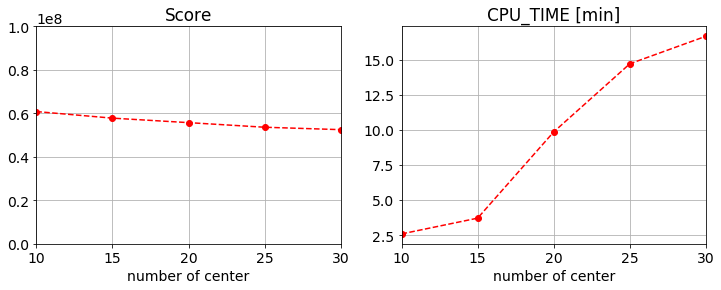

In [116]:
plt.rcParams['figure.figsize'] = (12,4)
#
plt.subplot(1,2,1)
plt.plot(centers, scores,'ro--' );
plt.xlabel('number of center')
plt.title('Score')
plt.grid()
plt.xlim([10,30])
plt.ylim([0,1.0e+8])
#
plt.subplot(1,2,2)
plt.plot(centers, cpu_times,'ro--' );
plt.xlabel('number of center')
plt.title('CPU_TIME [min]')
plt.grid()
plt.xlim([10,30])

In [117]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

### From the above  resutls, I select 15 centers.

In [256]:
kmeans15 = models[4]
labels_kmeans15 = kmeans15.predict(X_pca60)

In [257]:
print(labels_kmeans15.shape)
print( np.unique(labels_kmeans15) )

(623209,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


### Discussion 3.1: Apply Clustering to General Population
<span style="color:red">
- Q14 : Report your findings and decisions regarding clustering. <br>
- Q15 : Into how many clusters have you decided to segment the population?
</span>

### Discussion 3.1: <span style="color:red">Answer</span>
##### A14 & A15 : 
- From the above graph, when n = 30, score is the smallest.
- So, for 1st trial, I selected 30 centers.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters.<br>
<span stype="color:red">
Take care to not confuse this for re-fitting all of the models to the customer data.<br>
</span>
Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data.<br>
In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier.<br>
 (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [258]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [259]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [260]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data(customers, feat_info, my_dict);

azdias     = 
 74412     53
167357    53
61179     53
61178     53
61177     53
Name: num_nan, dtype: int64
----------------------------------
df_nan_col = 
               num_nan  ratio_nan  ids
TITEL_KZ       189340  98.793647   40
KK_KUNDENTYP   111937  58.406382   47
KBA05_BAUMAX   109535  57.153069   64
AGER_TYP        96738  50.475863    0
GEBURTSJAHR     93024  48.537975   11
----------------------------------
df_nan_row = 
    num_nan  ratio_nan     ids
0       53  62.352941   74412
1       53  62.352941  167357
2       53  62.352941   61179
3       53  62.352941   61178
4       53  62.352941   61177
-----------------------------
<  AGER_TYP  >
---> There is no data. This is already dropped.
-----------------------------
<  ANREDE_KZ  >
[1 2]
-----------------------------
<  CJT_GESAMTTYP  >
[6. 2. 4. 3. 1. 5.]
-----------------------------
<  FINANZTYP  >
[6 5 3 2 4 1]
-----------------------------
<  GFK_URLAUBERTYP  >
[ 8.  4. 10.  7.  3. 11.  1. 12.  5.  6.  2.  9.]
-------

In [261]:
X = StandardScaler().fit_transform(customers)
customers_scaled          = pd.DataFrame(X)
customers_scaled.columns  = customers.columns
customers_standarized     = StandardScaler().fit_transform(customers_scaled)
X_pca60_customers         = pca60.fit_transform(customers_standarized)
labels_kmeans15_customers = kmeans15.predict(X_pca60_customers)

### Add labels to azdias

In [262]:
azdias_labeled  = azdias.copy()
labels_kmeans15 = labels_kmeans15.reshape( len(labels_kmeans15), 1)
azdias_labeled['label'] = labels_kmeans15
#
azdias_labeled.sort_values('label', inplace=True)

In [263]:
azdias_labeled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,PRAEGENDE_JUGENDJAHRE_Decade,PRAEGENDE_JUGENDJAHRE_Move,CAMEO_INTL_2015_1,CAMEO_INTL_2015_2,label
751134,4.0,1,5,1,5,1,2,2,0,2.0,...,0,0,0,0,0,6.0,1.0,14,14,0
534289,4.0,1,4,1,5,1,2,5,0,3.0,...,0,0,0,0,0,6.0,1.0,14,14,0
153376,3.0,1,5,2,4,1,2,1,0,3.0,...,0,0,0,0,0,7.0,1.0,13,13,0
440672,4.0,2,3,1,5,2,1,5,0,2.0,...,0,0,0,0,0,5.0,1.0,14,14,0
324578,4.0,2,5,1,5,1,3,2,0,2.0,...,0,0,0,0,0,6.0,1.0,13,13,0


### Add labels to customers

In [264]:
customers_labeled          = customers.copy()
labels_kmeans15_customers  = labels_kmeans15_customers.reshape( len(labels_kmeans15_customers), 1)
customers_labeled['label'] = labels_kmeans15_customers
#
customers_labeled.sort_values('label', inplace=True)

In [265]:
customers_labeled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,RETOURTYP_BK_S,...,LP_STATUS_GROB_2,LP_STATUS_GROB_3,LP_STATUS_GROB_4,ZABEOTYP_0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,label
25667,3.0,1,5,1,5,1,1,2,1,5.0,...,0,0,1,1,0,0,0,0,0,0
19352,4.0,1,5,2,5,1,1,2,1,3.0,...,0,0,1,1,0,0,0,0,0,0
7519,3.0,1,5,1,5,1,1,3,0,5.0,...,0,1,0,1,0,0,0,0,0,0
23965,4.0,1,4,1,5,1,1,5,0,5.0,...,0,0,0,0,0,1,0,0,0,0
49599,4.0,1,5,1,5,1,2,2,1,5.0,...,0,0,1,0,0,1,0,0,0,0


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

### Compair the 2 DataFrame( Customers / Azdias )

In [266]:
col_list  = ['label','col_name','col_value','count_azdias','count_customer','ratio_azdias','ratio_customer','ratio_comp']
df_survey = pd.DataFrame( columns=col_list)
#
data_num_azdias   = azdias_labeled.shape[0]
data_num_customer = customers_labeled.shape[0]
#
col_names = azdias_labeled.columns
time_s    = time()
#
for i, col_name in enumerate(col_names):
    if not col_name in azdias_labeled.columns: continue
    if not col_name in customers_labeled.columns: continue
    col_val_unique = azdias_labeled[col_name].unique()
    col_val_unique = np.sort( col_val_unique )
    #
    for label in range(15):
        flag_row_A = (azdias_labeled['label'] == label)
        flag_rowl_C = (customers_labeled['label'] == label)
        #
        for col_val in col_val_unique:
            count_A = list(azdias_labeled[col_name] == col_val).count(True)
            count_C = list(customers_labeled[col_name] == col_val).count(True)
            ratio_A = count_A / data_num_azdias * 100
            ratio_C = count_C / data_num_customer * 100
            ratio_comp = ratio_C / (ratio_A + 0.001)
            #
            tmp_list  = [label, col_name, col_val, count_A, count_C, ratio_A, ratio_C, ratio_comp]
            tmp_sr    = pd.Series( tmp_list, index=df_survey.columns )
            df_survey = df_survey.append( tmp_sr, ignore_index=True )
#
print("CPU_TIME = {:.1f}".format( (time()-time_s)/60 ))

CPU_TIME = 4.3


In [267]:
df_survey.shape

(4095, 8)

In [268]:
df_survey.head()

,label,col_name,col_value,count_azdias,count_customer,ratio_azdias,ratio_customer,ratio_comp
0,0,ALTERSKATEGORIE_GROB,1.0,98597,28146,15.820856,15.186882,0.959867
1,0,ALTERSKATEGORIE_GROB,2.0,110594,18567,17.745893,10.018292,0.564510
2,0,ALTERSKATEGORIE_GROB,3.0,235521,56147,37.791656,30.295525,0.801625
3,0,ALTERSKATEGORIE_GROB,4.0,178497,82471,28.641595,44.499301,1.553606
4,1,ALTERSKATEGORIE_GROB,1.0,98597,28146,15.820856,15.186882,0.959867


In [269]:
if 0:
    col_names = azdias_labeled.columns

    for i, col_name in enumerate(col_names):
        if not col_name in azdias_labeled.columns: continue
        if not col_name in customers_labeled.columns: continue
        try:
            fig, (ax1,ax2) = plt.subplots(1,2)
            dummy = sns.catplot(x = col_name, y = 'label',data = azdias_labeled,    kind = 'boxen', ax=ax1);
            plt.close(dummy.fig);
            dummy = sns.catplot(x = col_name, y = 'label',data = customers_labeled, kind = 'boxen', ax=ax2);
            plt.close(dummy.fig);
        except:
            print('customer do not have {}.'.format(col_name))

In [270]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

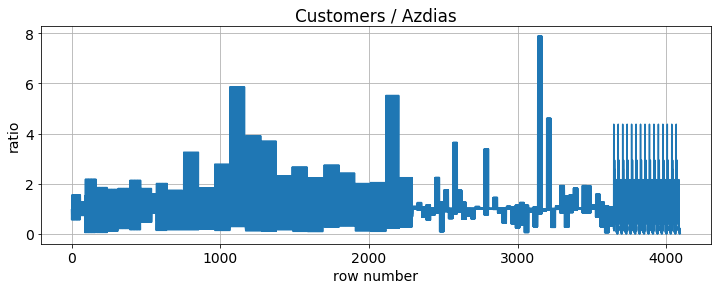

In [271]:
plt.plot( df_survey.index.values , df_survey['ratio_comp'].values );
plt.grid();
plt.xlabel('row number');
plt.ylabel('ratio');
plt.title('Customers / Azdias');

In [272]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

In [294]:
df_over = df_survey[ df_survey['ratio_comp'] >= 4.0 ].copy()

In [295]:
df_over.shape

(75, 8)

In [296]:
df_over.head()

,label,col_name,col_value,count_azdias,count_customer,ratio_azdias,ratio_customer,ratio_comp
1065,0,SEMIO_VERT,1.0,28810,50218,4.622847,27.096384,5.860138
1072,1,SEMIO_VERT,1.0,28810,50218,4.622847,27.096384,5.860138
1079,2,SEMIO_VERT,1.0,28810,50218,4.622847,27.096384,5.860138
1086,3,SEMIO_VERT,1.0,28810,50218,4.622847,27.096384,5.860138
1093,4,SEMIO_VERT,1.0,28810,50218,4.622847,27.096384,5.860138


In [297]:
col_names_over = df_over['col_name'].unique()
print( col_names_over.shape)
print( col_names_over)

(5,)
['SEMIO_VERT' 'HH_EINKOMMEN_SCORE' 'LP_STATUS_FEIN_4' 'LP_STATUS_FEIN_6'
 'label']


In [298]:
explanation_list = []
for i, col_name in enumerate(col_names_over):
    tmp_exp = get_explanation_from_my_dict( my_dict, col_name )
    #
    if tmp_exp not in explanation_list:
        explanation_list.append(tmp_exp)
        print(tmp_exp)

1-20 : SEMIO_VERT : 'Personality typology, for each dimension:'
2-4 : HH_EINKOMMEN_SCORE : 'Estimated household net income'
1-15 : LP_STATUS_FEIN_4 : 'Social status, fine scale'
1-15 : LP_STATUS_FEIN_6 : 'Social status, fine scale'
- : label : 


In [278]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

In [299]:
df_under = df_survey[ df_survey['ratio_comp'] <= 0.2 ].copy()

In [300]:
df_under.shape

(570, 8)

In [301]:
df_under.head()

,label,col_name,col_value,count_azdias,count_customer,ratio_azdias,ratio_customer,ratio_comp
90,0,FINANZ_MINIMALIST,1.0,102018,1676,16.369789,0.904328,0.05524
95,1,FINANZ_MINIMALIST,1.0,102018,1676,16.369789,0.904328,0.05524
100,2,FINANZ_MINIMALIST,1.0,102018,1676,16.369789,0.904328,0.05524
105,3,FINANZ_MINIMALIST,1.0,102018,1676,16.369789,0.904328,0.05524
110,4,FINANZ_MINIMALIST,1.0,102018,1676,16.369789,0.904328,0.05524


In [302]:
col_names_under = df_under['col_name'].unique()
print( col_names_under.shape)
print( col_names_under)

(20,)
['FINANZ_MINIMALIST' 'FINANZ_SPARER' 'FINANZ_VORSORGER'
 'FINANZ_UNAUFFAELLIGER' 'RETOURTYP_BK_S' 'SEMIO_SOZ' 'SEMIO_FAM'
 'SEMIO_REL' 'SEMIO_MAT' 'SEMIO_LUST' 'SEMIO_ERL' 'SEMIO_KULT' 'SEMIO_RAT'
 'SEMIO_KRIT' 'SEMIO_PFLICHT' 'SEMIO_TRADV' 'FINANZTYP_0'
 'LP_STATUS_FEIN_1' 'ZABEOTYP_4' 'label']


In [303]:
explanation_list = []
for i, col_name in enumerate(col_names_under):
    tmp_exp = get_explanation_from_my_dict( my_dict, col_name )
    #
    if tmp_exp not in explanation_list:
        explanation_list.append(tmp_exp)
        print(tmp_exp)

1-5 : FINANZ_MINIMALIST : 'Financial typology, for each dimension:'
1-5 : FINANZ_SPARER : 'Financial typology, for each dimension:'
1-5 : FINANZ_VORSORGER : 'Financial typology, for each dimension:'
1-5 : FINANZ_UNAUFFAELLIGER : 'Financial typology, for each dimension:'
1-19 : RETOURTYP_BK_S : 'Return type'
1-20 : SEMIO_SOZ : 'Personality typology, for each dimension:'
1-20 : SEMIO_FAM : 'Personality typology, for each dimension:'
1-20 : SEMIO_REL : 'Personality typology, for each dimension:'
1-20 : SEMIO_MAT : 'Personality typology, for each dimension:'
1-20 : SEMIO_LUST : 'Personality typology, for each dimension:'
1-20 : SEMIO_ERL : 'Personality typology, for each dimension:'
1-20 : SEMIO_KULT : 'Personality typology, for each dimension:'
1-20 : SEMIO_RAT : 'Personality typology, for each dimension:'
1-20 : SEMIO_KRIT : 'Personality typology, for each dimension:'
1-20 : SEMIO_PFLICHT : 'Personality typology, for each dimension:'
1-20 : SEMIO_TRADV : 'Personality typology, for each d

### Discussion 3.3: Compare Customer Data to Demographics Data
<span style="color:red">
- Q16 : Report findings and conclusions from the clustering analysis.<br>
- Q17 : Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?
</span>    

### Discussion 3.3: <span style="color:red">Answer</span>
##### A16 & A17 : 
- The people in that cluster to be a target audience for the company are below.
- 1-20 : SEMIO_VERT : 'Personality typology, for each dimension:'
- 2-4 : HH_EINKOMMEN_SCORE : 'Estimated household net income'
- 1-15 : LP_STATUS_FEIN_4 : 'Social status, fine scale'
- 1-15 : LP_STATUS_FEIN_6 : 'Social status, fine scale'


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.